# Weighted non-negative PARAFAC analysis on EEM data with scattering

## Import all requirements

In [1]:
# General data analysis and numerics
import numpy as np
import pandas as pd
import xarray
import scipy.io as io
from scipy.optimize import minimize, Bounds

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact
from wordcloud import WordCloud

# Tensor algorithms
import tensorly as tl
import tensorly.decomposition

# Visualisation of tensor decomposition models
from component_vis.postprocessing import postprocess

# General utilities
import calendar
import requests
import zipfile
from io import BytesIO
from tqdm import trange

## Download fluorescence spectroscopy on blood plasma from healthy controls and patients with colorectal cancer

**Info about dataset:** http://www.models.life.ku.dk/anders-cancer

**Data from:** Lawaetz, A.; Bro, R.; Kamstrup-Nielsen, M.; Christensen, I.; Jørgensen, L.; Nielsen, H. Fluorescence spectroscopy as a potential metabonomic tool for early detection of colorectal cancer. Metabolomics 8 (supplement 1): 111-121 (2012).

In [2]:
class RemoteZip:
    def __init__(self, url):
        req = requests.get(url)
        self.zip = zipfile.ZipFile(BytesIO(req.content))

    @property
    def contents(self):
        return [f.filename for f in self.zip.infolist()]
  
    def extract_file(self, filename):
        file_contents = self.zip.read(filename)
        data = BytesIO(file_contents)
        return data
  
    def extract_all(self):
        return {filename: self.extract_file(filename) for filename in self.contents}

data_zip = RemoteZip("http://models.life.ku.dk/sites/default/files/fluorescence_data_1.zip")
data = io.loadmat(data_zip.extract_file("fluorescence_data.mat"))

## Use measurements from undiluted blood (X_UD)

In [3]:
undiluted = data['X_UD']['data'].item().copy()
undiluted = xarray.DataArray(
    undiluted,
    coords=[
            ('Sample', np.arange(299)),
            ('Emission frequency', data['X_UD']['axisscale'].item()[1][0].squeeze()),
            ('Excitation frequency', data['X_UD']['axisscale'].item()[2][0].squeeze())
    ]
)

undiluted[0].plot()

### Some data is missing: Create mask and fill with zeros

In [4]:
mask = 1 - np.isnan(undiluted)
undiluted = undiluted.fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
undiluted[0].plot(ax=axes[0])
mask[0].plot(ax=axes[1])

## Fit a 10-component PARAFAC model

To handle missing data, we need some utilities, but first, we decide the number of components

In [5]:
rank = 10
tensor = undiluted.values
tensor_mask = mask.values

### Functions to transform a `CPTensor` object into a vector and back again

`CPTensor` is the name that TensorLy uses for objects that represent PARAFAC decompositions. There is a `CPTensor` class interface, which is compatible with a tuple whose first element is the weight of each component (or None, if all weights are equal to 1) and second element is a list of factor matrices.

In [6]:
def ravel_cp_tensor(cp_tensor):
    """Collect all parameters of a CP tensor into a 1D vector.
    """
    size = rank * sum(tensor.shape)
    out = np.empty(size)
    pos = 0
    for factor in cp_tensor[1]:
        out[pos:pos + np.size(factor)] = factor.ravel()
        pos += np.size(factor)
    return out

def unravel_cp_tensor(vectorised_cp_tensor):
    """Convert a 1D vector into a CP tensor compatible object.
    """
    out = []
    pos = 0
    for length in tensor.shape:
        out.append(vectorised_cp_tensor[pos:pos + length*rank].reshape(length, rank))
        pos += length*rank
    return None, out

### Function to compute the sum of squared errors (times 0.5) and gradient with respect to a vectorised CPTensor

This funcitonality is not yet public, so to get it, we need to install the latest development branch of TensorLy. You can do this by running

```
pip install git+https://github.com/tensorly/tensorly.git
```

In [7]:
def loss_and_grad(x):
    """Compute the least squares loss and gradient for a vectorised CP tensor
    """
    cp_tensor = unravel_cp_tensor(x)
    grad, loss = tl.cp_tensor.cp_lstsq_grad(cp_tensor, tensor, return_loss=True, mask=tensor_mask)
    return loss, ravel_cp_tensor(grad)

### Initialise with a random PARAFAC model

In [8]:
weights = None
factors = [np.random.uniform(size=(length, rank)) for length in tensor.shape]
init = weights, factors

### Use scipy optimize minimize to fit a non-negative CP model using L-BFGS-B

In [9]:
maxiter = 100

# Make a progress bar
progressbar = iter(trange(maxiter))
def progressbar_callback(*args):
  next(progressbar)

res = minimize(
    loss_and_grad,
    x0=ravel_cp_tensor(init),
    method="l-bfgs-b",
    callback=progressbar_callback,
    jac=True,
    options=dict(maxiter=maxiter,),
    bounds=Bounds(0, np.inf)
)

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:23<00:00,  4.67it/s]

## Label the fitted model with the data

In [10]:
parafac = unravel_cp_tensor(res.x)
parafac = postprocess(parafac, dataset=undiluted)

## Plot the components

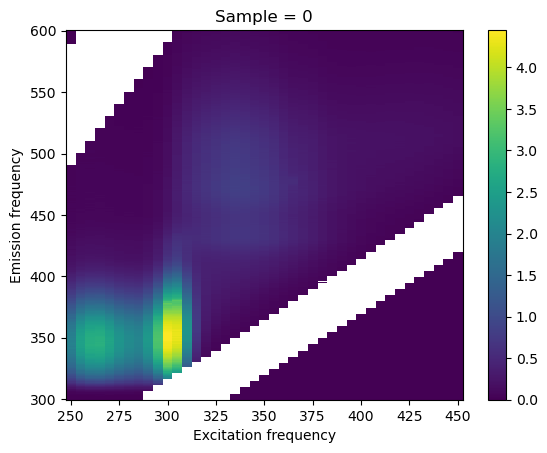

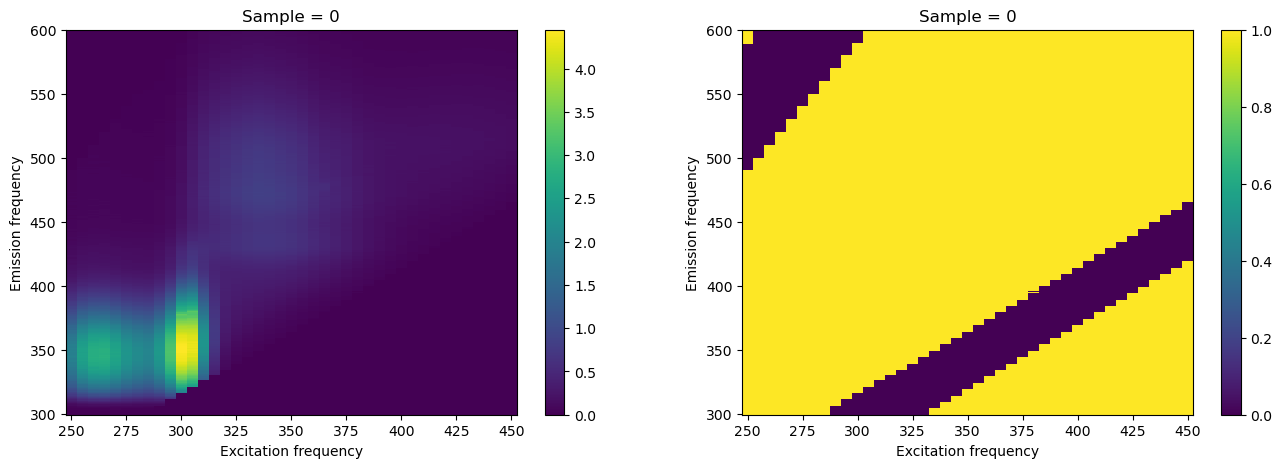

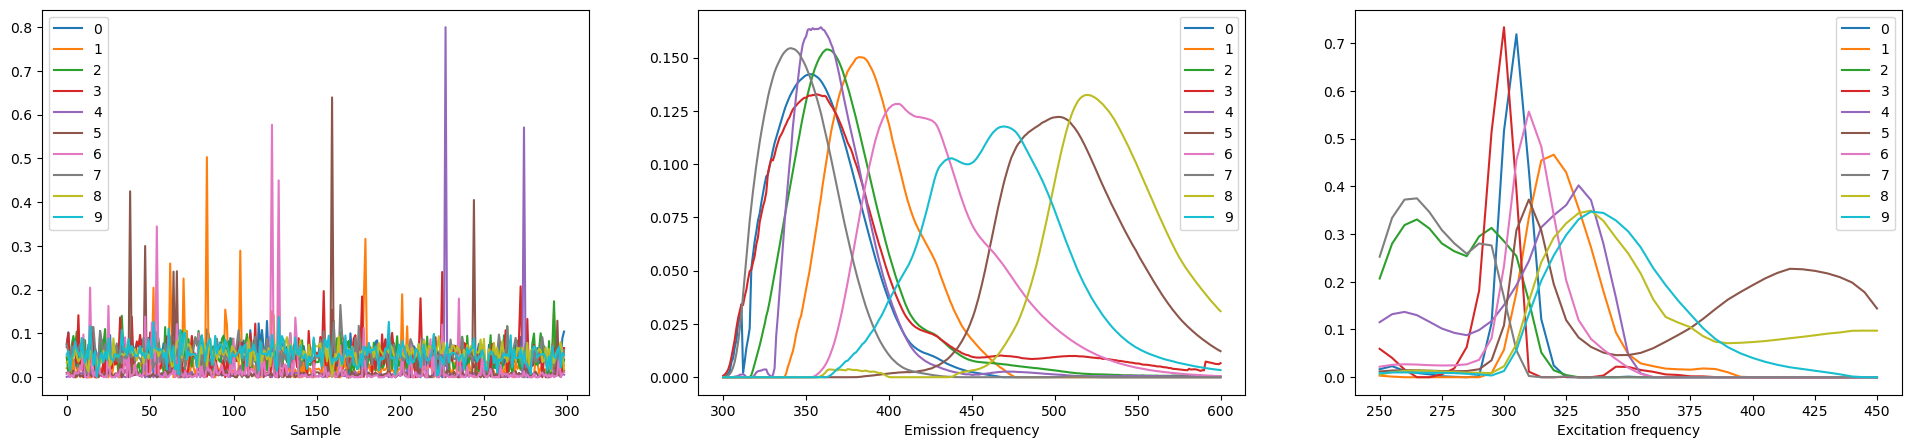

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))
parafac[1][0].plot(ax=axes[0])
parafac[1][1].plot(ax=axes[1])
parafac[1][2].plot(ax=axes[2])
plt.show()